# Contrast Transfer Function
The Contrast Transfer Function (CTF) describes the aberrations of the objective lens in HRTEM and specifies how the condenser system shapes the probe in STEM. Here we describe how to create a CFT with specific aberrations, and how this affects the resulting images.

## Polar expansion of the phase error

Ideally, a lens forms a spherical wave converging on or emerging from a single point. In practice, aberrations cause the wave front to deviate from a spherical surface. This deviation can be represented as a phase error, $\chi(k, \phi)$, of the spatial frequency in polar coordinates. The phase error can be written as a series expansion

$$ 
    \chi(\alpha, \phi) = \frac{2 \pi}{\lambda} \sum_{n,m} \frac{1}{n + 1} C_{n,m} (k \lambda)^{n+1} \cos\left[m (\phi - \phi_{n,m}) \right] \quad ,
$$

where $n,m$ index the different aberrations.

If the microscope is well aligned then off-axis aberrations (astigmatisms) are small and the phase error is dominated by the first two isotropic terms

$$
    \chi(k) \approx \frac{2\pi}{\lambda}\left( \frac{\lambda^2 k^2}{2} \Delta f + \frac{\lambda^4 k^4}{4} C_s \right) \quad ,
$$

where $\Delta f = -C_{1,1}$ is the defocus and $C_s=C_{3,3}$ is the third order spherical aberration.

The `CTF` object takes parameters of the form `Cnm` and `phinm`, and may also be given using their common aliases, e.g. `defocus = -C10`. The expansion is implemented up to 5th order, and all the coefficients labels are shown in the table below.

abTEM exclusively uses polar expansion coefficients; however, a conversion utility from the Cartesian to the polar representation is available in `abtem.transfer.cartesian2polar`.

## Creating a Contrast Transfer Function and applying phase aberrations

We create a `CTF` object with an electron energy of $300 \ \mathrm{keV}$, a spherical aberration of $-7~\mu \mathrm{m}$ (remember that abTEM uses units of Å) and the [Scherzer defocus](https://en.wikipedia.org/wiki/High-resolution_transmission_electron_microscopy) (here $-45.5 \ \mathrm{Å}$).

In [1]:
from abtem.transfer import CTF, scherzer_defocus, point_resolution, energy2wavelength
import matplotlib.pyplot as plt
import numpy as np

Cs = -7e-6 * 1e10
ctf = CTF(Cs=Cs, energy=300e3)
ctf.defocus = scherzer_defocus(Cs, ctf.energy)

print(ctf.defocus)

-45.46632087888138


This can also be accomplished by setting the parameters with a dictionary.

In [2]:
parameters = {'C10': - ctf.defocus, 'C30': Cs}
ctf2 = CTF(parameters=parameters, energy=300e3)

We can use the function `plot_ctf` to preview the CTF along a radial direction up to a given angle (in radians).

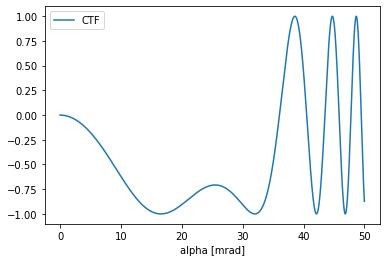

In [3]:
ctf.show(50)

Given the exit wave function $\phi_{exit}$ and the phase error $\chi$, the wave function at the image plane is given by

$$  
    \phi_{image}(\alpha, \phi) = \phi_{exit}(\alpha, \phi) \exp(-i \chi(\alpha, \phi)) \quad .
$$


To perform this operation, we use the `apply_ctf` method. Here we apply the CTF to the exit wave from an earlier tutorial.

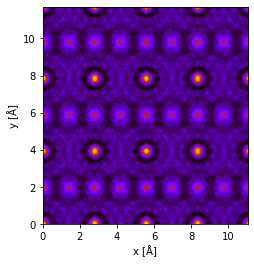

In [4]:
from abtem.waves import Waves

exit_wave = Waves.read('data/srtio3_exit_wave.hdf5')
image_wave1 = exit_wave.apply_ctf(ctf)
image_wave1.show(cmap='gnuplot');

## Aperture and partial coherence

The CTF is further limited by any aperture present and by partial coherence. This is conventionally described as a multiplication with the aperture function, $A(k)$, and a partial coherence envelope, $E(k)$. Hence, the wave function at the image plane becomes

$$
    \phi_{\mathrm{image}}(\alpha, \phi) = \phi_{\mathrm{exit}}(\alpha, \phi) E(k) A(k) \exp[-i \chi(\alpha, \phi)] \quad .
$$

The aperture function cuts off beams scattered above a certain critical angle

$$
    A(k) = \begin{cases} 1 & \text{if } x \geq k_{cut} \\ 0 & \text{if } x < k_{cut} \end{cases} .
$$

We will cut off the CTF at the angle corresponding to the Scherzer point resolution, which is defined as the angle where the CTF crosses the abscissa for the first time (here converted to mrad).

36.042166130750395


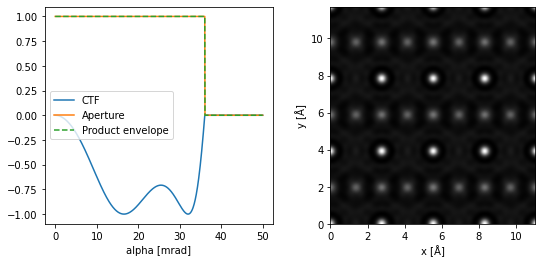

In [5]:
ctf.semiangle_cutoff = 1000 * energy2wavelength(ctf.energy) / point_resolution(ctf.Cs, ctf.energy)
print(ctf.semiangle_cutoff)

image_wave = exit_wave.apply_ctf(ctf)

fig,(ax1,ax2) = plt.subplots(1,2, figsize=(9,4))
ctf.show(50, ax=ax1)
image_wave.show(ax=ax2)

The partial coherence envelope function $E(k)$ smoothly dampens the signal of beams scattered to high angles. Its most important contribution is generally the focal spread, or, equivalently the chromatic aberration.

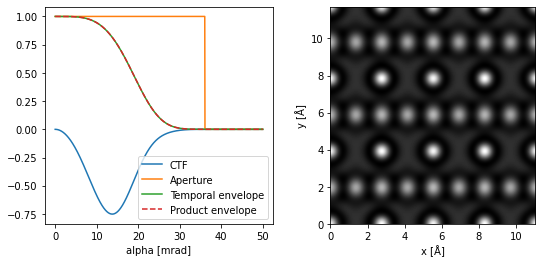

In [6]:
ctf.focal_spread = 30
image_wave2 = exit_wave.apply_ctf(ctf)

fig,(ax1,ax2) = plt.subplots(1,2, figsize=(9,4))
ctf.show(50, ax=ax1)
image_wave2.show(ax=ax2)

## Probes and CTFs

The contrast transfer function can also be calculated for a focused probe.

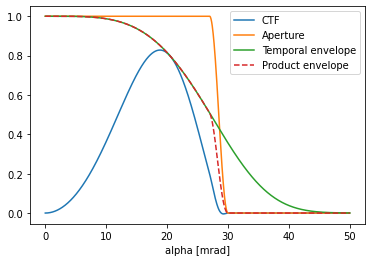

In [7]:
from abtem.waves import Probe

probe = Probe(sampling=.025, extent=10, energy=80e3, semiangle_cutoff=30, focal_spread=30, defocus=50)
probe.ctf.show(50)

We can further model the effect of different types of aberrations on our probe by changing the parameters of the contrast transfer function.

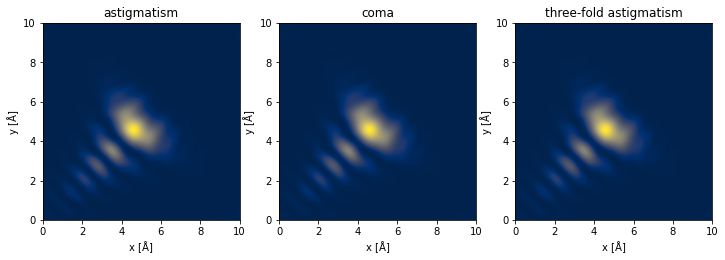

In [9]:
from copy import copy

fig, (ax1,ax2,ax3)= plt.subplots(1,3, figsize=(12,4))

probe_copy = copy(probe)
probe_copy.ctf.set_parameters({'C12': 20, 'phi12': np.pi / 4})
probe_copy.show(ax=ax1, cmap='cividis', title='astigmatism')

probe_copy = copy(probe)
probe_copy.ctf.set_parameters({'C21': 5000, 'phi21': np.pi / 4})
probe_copy.show(ax=ax2, cmap='cividis', title='coma')

probe_copy = copy(probe)
probe_copy.ctf.set_parameters({'C23': 2500, 'phi23': np.pi / 4})
probe_copy.show(ax=ax3, cmap='cividis', title='three-fold astigmatism');